<a href="https://colab.research.google.com/github/Yun-K/COMP261_a5_stringSearch_and_2compressionAlgorithms/blob/main/train_best_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Name: Yun Zhou
# ID:   300442776
#  # for using the vs code on colab
#  !pip install colabcode
# from colabcode import ColabCode
# ColabCode(port=10000,password="12345")

In [2]:
!pip install torchmetrics

     |████████████████████████████████| 282 kB 5.2 MB/s 


import libraries

In [3]:

import os
import time

import cv2
# import helper
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch  # PyTorch
import torch.autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchmetrics  # metrics like accuracy, recall, etc
import torchvision
import torchvision.transforms as transforms  # for image Transformation
import tqdm
from PIL import Image
from sklearn.datasets import load_digits
from sklearn.metrics import (accuracy_score, confusion_matrix, make_scorer,
                             mean_absolute_error, mean_squared_error,
                             precision_recall_fscore_support, recall_score,
                             roc_auc_score)
from sklearn.model_selection import (KFold, LeaveOneOut, ShuffleSplit,
                                     cross_val_score, cross_validate,
                                     train_test_split)
from sklearn.neural_network import MLPClassifier, MLPRegressor
from torch import nn
from torch.autograd import Variable
from torch.nn.modules.container import Sequential
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import (CosineAnnealingLR, ReduceLROnPlateau,
                                      StepLR)
from torch.utils.data import DataLoader, Dataset, TensorDataset, random_split
from torch.utils.data.sampler import SubsetRandomSampler  # Sampler
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder

# import myutil


initialize some necessary global variable
And set up google colab path 
> https://medium.com/analytics-vidhya/how-to-use-google-colab-with-github-via-google-drive-68efb23a42d

In [4]:
# for using CPU or GPU
# import torch 
DEVICE = ('cuda' if torch.cuda.is_available() else 'cpu')
print("we can use:", DEVICE, "to run the Model ")

isColab = True  if torch.cuda.is_available() else False
# isColab = !isColab #for CPU on colab

from google.colab import drive
drive.mount('/content/gdrive')
if isColab:
  print("Use google drive")
  # !cd /content/gdrive/MyDrive/ && ls

PREFIX_PATH = "/content/gdrive/MyDrive/"
DATA_PATH = "/content/gdrive/MyDrive/traindata" if isColab else "../traindata"



we can use: cuda to run the Model 
Mounted at /content/gdrive
Use google drive


load, preprocess and construct the dataset 

In [5]:
BATCH_SIZE = 64
train_size_coef = 0.8
RANDOM_SEED = 309

def load_preprocess_construct_data(path=DATA_PATH,BATCH_SIZE = BATCH_SIZE):
    dataset_whole = ImageFolder(path, transform=transforms.Compose(
        [
            # scale each images into the same size
            transforms.Resize((300, 300)),
            transforms.ToTensor(),  # transform them into tensor

            # normalize tensor images with mean and std
            # which means all channel of the input tensor images will be normalized
            transforms.Normalize(mean=(0.5, 0.5, 0.5),
                                 std=(0.5, 0.5, 0.5), inplace=False),
            transforms.RandomRotation(degrees=(0, 180))
        ])
    )
    print("whole set len:", len(dataset_whole))
    # split the data into train/valid set
    train_set, valid_set = train_test_split(dataset_whole, train_size=train_size_coef,
                                            random_state=RANDOM_SEED)
    # shuffle:TRUE means random sample
    # drop_last:False will make sure that no images will be droped even there are no enough BATCH_SIZE(e.g. 64) images at the last round
    train_loader = DataLoader(
        train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, drop_last=False)
    valid_loader = DataLoader(
        valid_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, drop_last=False)

    print(dataset_whole.classes)

    print("whole set len:", len(dataset_whole))
    print("train set len:", len(train_set))
    print("valid set len:", len(valid_set))
    print("train+valid set len:", len(train_set)+len(valid_set))

    return dataset_whole, train_set, valid_set, train_loader, valid_loader


dataset_whole, train_set, valid_set, train_loader, valid_loader = load_preprocess_construct_data()


whole set len: 5026
['cherry', 'strawberry', 'tomato']
whole set len: 5026
train set len: 4020
valid set len: 1006
train+valid set len: 5026


 use the tensorboard for visualize the data more convenient
 
 ``` 
tensorboard --logdir=preprocess
 ```

In [6]:
# preprocess_path  = "/content/gdrive/MyDrive/Colab_Notebooks/preprocess" if isColab else "preprocess"
# writer = SummaryWriter(preprocess_path)
# preprocess_step = 0
# for (image_X,target_Y) in train_loader:
#     # imgtensor=y-axis, global step = x axis
#     writer.add_images(tag="data", img_tensor=image_X, global_step=preprocess_step)
#     preprocess_step = preprocess_step + 1
# writer.close()

get the model 

In [7]:
# # https://www.kaggle.com/artgor/simple-eda-and-model-in-pytorch/notebook
# # https://www.mashen.zone/thread-1825047.htm
# # https://blog.csdn.net/nanke_4869/article/details/113458729
# # CNN model
# class CNN(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.conv1 = nn.Sequential(            
#             nn.Conv2d(
#               in_channels=3,# Number of channels in the input image:input height,mark the amount of color channels,it is 3 since RGB is 3 channel
#               out_channels=64,#n_filter, Number of channels produced by the convolution
#               kernel_size=3,#filter size
#               stride=1,#filter step, Stride of the convolution
#               padding=1# controls the amount of padding applied to the inpu
#             ),
#             # Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift
#             nn.BatchNorm2d(32),
                        
#             nn.Conv2d(
#               in_channels=64,# Number of channels in the input image:input height,mark the amount of color channels
#               out_channels=64,#n_filter, Number of channels produced by the convolution
#               kernel_size=3,#filter size
#               stride=1,#filter step, Stride of the convolution
#               padding=1# controls the amount of padding applied to the inpu
#             ),
#             # activation function
#             nn.ReLU(inplace = True),
#             # https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md
#             # pooling
#             nn.MaxPool2d(2),
            
#             # use dropout to enable a kind of early stop which can avoid the over-fit 
#             nn.Dropout(0.3)    
#         )
#         self.conv2 = nn.Sequential(
#             nn.Conv2d(
#               in_channels=64,# Number of channels in the input image:input height,mark the amount of color channels
#               out_channels=128,#n_filter, Number of channels produced by the convolution
#               kernel_size=3,#filter size
#               stride=1,#filter step, Stride of the convolution
#               padding=1# controls the amount of padding applied to the inpu
#             ),
#             nn.Conv2d(
#               in_channels=128,# Number of channels in the input image:input height,mark the amount of color channels
#               out_channels=128,#n_filter, Number of channels produced by the convolution
#               kernel_size=3,#filter size
#               stride=1,#filter step, Stride of the convolution
#               padding=1# controls the amount of padding applied to the inpu
#             ),
#             nn.ReLU(inplace = True),
#             # pooling
#             nn.MaxPool2d(2),
#             # use dropout to enable a kind of early stop which can avoid the over-fit 
#             nn.Dropout(0.3)
#         )
#         self.conv3 = nn.Sequential(
#             nn.Conv2d(
#               in_channels=128,# Number of channels in the input image:input height,mark the amount of color channels
#               out_channels=256,#n_filter, Number of channels produced by the convolution
#               kernel_size=3,#filter size
#               stride=1,#filter step, Stride of the convolution
#               padding=1# controls the amount of padding applied to the inpu
#             ),
#             nn.Conv2d(
#               in_channels=256,# Number of channels in the input image:input height,mark the amount of color channels
#               out_channels=256,#n_filter, Number of channels produced by the convolution
#               kernel_size=3,#filter size
#               stride=1,#filter step, Stride of the convolution
#               padding=1# controls the amount of padding applied to the inpu
#             ),
#             nn.ReLU(inplace = True),
#             nn.MaxPool2d(2),
#             # use dropout to enable a kind of early stop which can avoid the over-fit 
#             nn.Dropout(0.3)
#         )
#         self.conv4 = nn.Sequential(
#             nn.Conv2d(
#               in_channels=256,# Number of channels in the input image:input height,mark the amount of color channels
#               out_channels=512,#n_filter, Number of channels produced by the convolution
#               kernel_size=3,#filter size
#               stride=1,#filter step, Stride of the convolution
#               padding=1# controls the amount of padding applied to the inpu
#             ),
#             nn.Conv2d(
#               in_channels=512,# Number of channels in the input image:input height,mark the amount of color channels
#               out_channels=512,#n_filter, Number of channels produced by the convolution
#               kernel_size=3,#filter size
#               stride=1,#filter step, Stride of the convolution
#               padding=1# controls the amount of padding applied to the inpu
#             ),
#             nn.ReLU(inplace = True),
#             nn.MaxPool2d(2),
#             # use dropout to enable a kind of early stop which can avoid the over-fit 
#             nn.Dropout(0.3)
#         )

#         self.flatten = nn.Flatten()
#         self.fc1 = nn.Sequential(
#             nn.Linear(512*18*18,512),
#             # use dropout to enable a kind of early stop which can avoid the over-fit 
#             nn.Dropout(0.3),
#         )
#         self.fc2 = nn.Sequential(
#             nn.Linear(512,3)
#         )
        

#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.conv2(x)
#         x = self.conv3(x)
#         x = self.conv4(x)
#         x = self.flatten(x)
#         x = self.fc1(x)
#         x = self.fc2(x)
#         return x

#     def to_model_string(self):
#         return 'CNN'



# something has to be commented out since no enough GPU memory in Colab
class CNN(nn.Module):
  """
https://datascience.stackexchange.com/questions/40906/determining-size-of-fc-layer-after-conv-layer-in-pytorch
  https://towardsdatascience.com/classification-of-fruit-images-using-neural-networks-pytorch-1d34d49342c7
  """
  def __init__(self):
      super().__init__()
      self.network = nn.Sequential(
          nn.Conv2d(in_channels=3, out_channels= 32, kernel_size=3, stride=1, padding=1), #3 channels to 32 channels
          # Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift
          nn.BatchNorm2d(32),
          nn.ReLU(inplace = True), # activitation function 
          nn.MaxPool2d(2, 2), # output: 32 channels x 150 x 150 image size - decrease
          nn.Dropout(0.25), 

          nn.Conv2d(in_channels=32, out_channels= 64, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(64),
          nn.ReLU(inplace = True), # activitation function 
          nn.MaxPool2d(2, 2), # output: 64 x 75 x 75
          # use dropout to enable a kind of early stop which can avoid the over-fit 
          nn.Dropout(0.25), 

          nn.Conv2d(in_channels=64, out_channels= 128, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(128),
          nn.ReLU(inplace = True), # activitation function 
          nn.Conv2d(in_channels=128, out_channels= 128, kernel_size=3, stride=1, padding=1), #can keep the same, increase power of model , go deeper as u add linearity to non-linearity
          # nn.BatchNorm2d(128),
          nn.ReLU(inplace = True), # activitation function 
          nn.MaxPool2d(3, 3), # output: 128 x 25 x 25
          # use dropout to enable a kind of early stop which can avoid the over-fit 
          nn.Dropout(0.25), 

          nn.Conv2d(in_channels=128, out_channels= 256, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(256),
          nn.ReLU(inplace = True), # activitation function 
          nn.Conv2d(in_channels=256, out_channels= 256, kernel_size=3, stride=1, padding=1),
          nn.ReLU(inplace = True), # activitation function 
          nn.Dropout(0.25), 
          
          nn.Conv2d(in_channels=256, out_channels= 512, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(512),
          # nn.MaxPool2d(2),
          nn.ReLU(inplace = True), # activitation function 
          # nn.Conv2d(in_channels=256, out_channels= 256, kernel_size=3, stride=1, padding=1),
          # nn.BatchNorm2d(512),
          # nn.MaxPool2d(2),
          # nn.ReLU(inplace = True), # activitation function 
          nn.MaxPool2d(5, 5), # output: 512 x 5 x 5
          # use dropout to enable a kind of early stop which can avoid the over-fit 
          nn.Dropout(0.25), 

          # nn.Conv2d(in_channels=256, out_channels= 512, kernel_size=3, stride=1, padding=1),
          # nn.BatchNorm2d(512),
          # nn.ReLU(inplace = True), # activitation function 
          # # nn.Conv2d(in_channels=512, out_channels= 512, kernel_size=3, stride=1, padding=1),
          # nn.BatchNorm2d(512),
          # # nn.MaxPool2d(2),
          # nn.ReLU(inplace = True), # activitation function 
          # nn.MaxPool2d(5, 5), # output: 512 x 5 x 5
          # # use dropout to enable a kind of early stop which can avoid the over-fit 
          # nn.Dropout(0.25), 

          nn.Flatten(), #a single vector 512*5*5,
          nn.Linear(512*5*5, 512),
          nn.ReLU(inplace = True), # activitation function 
          nn.Dropout(0.25), 

          # nn.ReLU(inplace = True), # activitation function 
          # nn.Linear(1024, 512),
          # nn.ReLU(),
          nn.Linear(512, 3)
          

          # nn.Dropout(0.25), 
          # 512,131 on towardsDatascience, dont know what it is , 
          # I think it might be the batch_size(128) + classes(3)?
          # need to test performances
          # nn.Linear(512, 131) 
          
          )
      
  def forward(self, xb):
      return self.network(xb)


  def to_model_string(self):
      return 'CNN'


In [8]:
DEVICE = ('cuda' if torch.cuda.is_available() else 'cpu')
print("we can use:", DEVICE, "to run the Model ")
model = CNN().to(DEVICE) #enable the GPU trian if we can 
print("Our model: ")
print(model)

we can use: cuda to run the Model 
Our model: 
CNN(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.25, inplace=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout(p=0.25, inplace=False)
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(in

performance metric

In [9]:
def get_accuracy(net, testloader):
    """
    NOT USED in my CODE
    this code snipest is from:
    https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
    """
    correct, total = 0, 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            # calculate outputs by running images through the network
            outputs = net(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total  # * 100

for adjusting lr based on epoches, which is about scheduler
> https://pytorch.org/docs/stable/optim.html
> https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CosineAnnealingWarmRestarts.html
> `https://zhuanlan.zhihu.com/p/261134624`

>https://stackoverflow.com/questions/65343377/adam-optimizer-with-warmup-on-pytorch

>`https://www.reddit.com/r/MachineLearning/comments/oy3co1/d_how_to_pick_a_learning_rate_scheduler/`
>`https://www.jeremyjordan.me/nn-learning-rate/`
>
>https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CosineAnnealingWarmRestarts.html
>
>
>

In [10]:

# initialize the torch metric  of accuracy
train_accuracy = torchmetrics.Accuracy().to(DEVICE)
valid_accuracy = torchmetrics.Accuracy().to(DEVICE)
# torchmetrics.Precision().to(DEVICE) #dont count other metrics since it is time consuming 

loss_function = nn.CrossEntropyLoss().to(DEVICE)

LEARNING_RATE, MOMENTUM = 0.0001, 0.9
# A Method for Stochastic Optimization_. The implementation of the L2 penalty follows changes proposed in Decoupled Weight Decay Regularization_.
optimizer = optim.Adam(model.parameters() ,lr=LEARNING_RATE) # lr=0.001 is default lr for Adam, set to higher since we use scheduler

# 
# optimizer = optim.RMSprop(model.parameters(),lr=LEARNING_RATE, momentum=MOMENTUM)
# optimizer = optim.SGD(model.parameters(),lr=LEARNING_RATE, momentum=MOMENTUM)

# optimizer = optim.SGD(model.parameters(),lr=LEARNING_RATE, momentum=MOMENTUM)
# optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.99)

# scheduler = CyclicLR(optimizer, base_lr=lr, max_lr=0.01, step_size=5, mode='triangular2')
# scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
# scheduler = lr_scheduler.CosineAnnealingLR(optimizer)

# scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=5,T_mult=2)



train the model several epoches

In [11]:
# assert False
model = model.train()
total_step, valid_loss_min, valid_acc_best = 0, np.Inf, np.Inf
loss_train_list, loss_val_list, acc_train_list, acc_valid_list, cur_lr_list = [], [], [], [], []

best_model = {} # for storing the best mode based on the lowest loss 
p = 0  # epoch numers of the validation set loss didn't decrease
stop = False  # whether stop the training process

iters = len(train_loader)
epoch_num = 75 if model.to_model_string()=='CNN' else 15
print('total epoch num',epoch_num)
for epoch in range(0, epoch_num):
    if stop:
        break
        
    # reset for current epoch
    train_accuracy.reset()
    valid_accuracy.reset()

    train_loss = []

    for batch_index, (image_X, target_Y) in enumerate(train_loader):
        total_step = total_step+1
        # enable the GPU train if we can
        image_X, target_Y = image_X.to(DEVICE), target_Y.to(DEVICE)

        # Sets the gradients of all optimized torch.Tensor s to zero.
        optimizer.zero_grad()

        # do the forward , back-propagation, and optimize
        outputs = model(image_X)
        loss = loss_function(outputs, target_Y)
        train_loss.append(loss.item())

        # store the accuracy
        preds = torch.max(outputs, 1)[1]
        train_accuracy(preds, target_Y)  # TODO:

        # BACKWARD and optimize
        loss.backward()
        optimizer.step()
        # #If call scheduler.step() after the end of an epoch,(i.e.outside this for loop)
        # #Then all batches in an epoch use the same learning rate,
        # #in order to make different batches use different learning rates
        # #we call it in there
        # scheduler.step(epoch + batch_index / iters)
        # cur_lr=optimizer.param_groups[-1]['lr']
        # cur_lr_list.append(cur_lr)
        ## print('cur_lr:',cur_lr)
    # print('epoch_{}_end'.format(epoch))

    # scheduler.step(epoch) 
    cur_lr=optimizer.param_groups[-1]['lr']
    cur_lr_list.append(cur_lr)

    final_train_acc = train_accuracy.compute().item()  # * 100
    acc_train_list.append(final_train_acc)
    # FIXME: DIFF ???  use np.mean() or need to divide by len(trainset)
    final_train_loss_mean = np.sum(train_loss)/len(train_set)
    loss_train_list.append(final_train_loss_mean)

    # for validation set
    model.eval()
    val_loss = []
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for batch_index, (image_X, target_Y) in enumerate(valid_loader):
            # enable the GPU  if we can
            image_X, target_Y = image_X.to(DEVICE), target_Y.to(DEVICE)
            outputs = model(image_X)
            loss = loss_function(outputs, target_Y)
            val_loss.append(loss.item())

            # store the accuracy
            preds = torch.max(outputs, 1)[1]
            valid_accuracy(preds, target_Y)  # TODO:
    final_valid_acc = valid_accuracy.compute().item()  # * 100
    acc_valid_list.append(final_valid_acc)

    # FIXME: DIFF ???  use np.mean() or need to divide by len(trainset)
    final_valid_loss_mean = np.sum(val_loss)/len(valid_set)
    loss_val_list .append(final_valid_loss_mean)
    print('-'*70)
    print('-'*70)
    print(time.ctime())
    print(
        f'Epoch {epoch}:', '\n', f'training step:{total_step}, train loss: {final_train_loss_mean:.7f}, valid loss: { final_valid_loss_mean:.7f}', \
        '\n',f"Learning rate:{cur_lr}" )
    print(f"Train set accuracy: {final_train_acc:.7f}")
    print(f"Valid set accuracy: {final_valid_acc:.7f}")

    # scheduler.step(final_valid_loss_mean)

    # check if the loss on valid set is improved or not
    if final_valid_loss_mean <= valid_loss_min: # and final_valid_acc <= valid_acc_min:
        print('-'*10)
        print('Validation loss decreased ({:.8f} --> {:.8f}).  Saving model ...'.format(
            valid_loss_min,
            final_valid_loss_mean))
        # torch.save(model.state_dict(), MODEL_SAVE_PATH)
        valid_loss_min = final_valid_loss_mean
        valid_acc_best = final_valid_acc
        best_model['Best epoch'] = epoch
        best_model['model'] = model.state_dict() # assign this model since it perform better
        best_model['Best Acc on validation set'] = valid_acc_best
        best_model['Best(lowest) validation loss'] = valid_loss_min

        # for k,v in best_model.items():
        #   if k is not 'model':
        #     print(f"{k}: {v}")
        # print('-'*10)
        p = 0  # reset P
    else:
        print('-'*10)
        p += 1
        print(f'{p} epochs of increasing validation loss')
        if p >= 15:
            print(f'Stopping training since no improvement on the validation loss over {p} epoches ')
            stop = True
            break



total epoch num 75


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


----------------------------------------------------------------------
----------------------------------------------------------------------
Fri Oct 22 08:32:07 2021
Epoch 0: 
 training step:63, train loss: 0.0193936, valid loss: 0.0177461 
 Learning rate:0.0001
Train set accuracy: 0.3950249
Valid set accuracy: 0.3479125
----------
Validation loss decreased (inf --> 0.01774611).  Saving model ...
----------------------------------------------------------------------
----------------------------------------------------------------------
Fri Oct 22 08:33:16 2021
Epoch 1: 
 training step:126, train loss: 0.0166164, valid loss: 0.0161118 
 Learning rate:0.0001
Train set accuracy: 0.4199005
Valid set accuracy: 0.5000000
----------
Validation loss decreased (0.01774611 --> 0.01611183).  Saving model ...
----------------------------------------------------------------------
----------------------------------------------------------------------
Fri Oct 22 08:34:25 2021
Epoch 2: 
 training ste

plot the graph 

Finished the training process and plot graphs
RED is for validation set, BLUE is for train set 


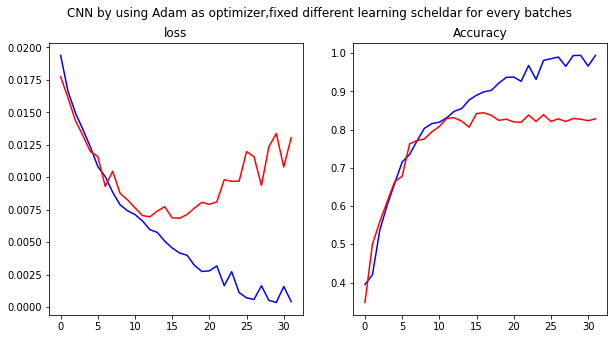

In [12]:
plt.figure(figsize=(10, 5))
plt.suptitle(model.to_model_string()+" by using Adam as optimizer,fixed different learning scheldar for every batches")

plt.subplot(1, 2, 1).set_title('loss')
plt.plot(loss_train_list, color='blue', label='train set')
plt.plot(loss_val_list, color='red', label='valid set')
plt.subplot(1, 2, 2).set_title('Accuracy')
plt.plot(acc_train_list, color='blue', label='train set')
plt.plot(acc_valid_list, color='red', label='valid set')
print('Finished the training process and plot graphs')
print("RED is for validation set, BLUE is for train set ")
plt.show()


plot graph for learning rate changes


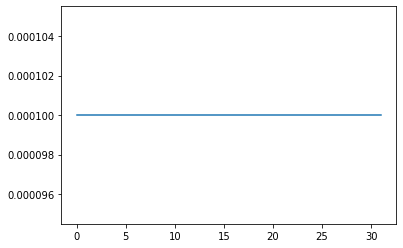

In [13]:
print('plot graph for learning rate changes')
x_list = list(range(len(cur_lr_list)))
plt.plot(x_list, cur_lr_list,label="learning rate plot")
plt.show()

In [14]:
# assert False
assert best_model is not None, "best model is not assigned correctly on above code"
SAVE_PATH = "/content/gdrive/MyDrive/Colab_Notebooks/model_Adam.pth"
torch.save(best_model['model'], SAVE_PATH)
for k,v in best_model.items():
  if k is not 'model':
    print(f"{k}: {v}")

Best epoch: 16
Best Acc on validation set: 0.8439363837242126
Best(lowest) validation loss: 0.006838291083605104
